<a href="https://colab.research.google.com/github/notsrujangupta/Start_Hack_SBB_Project_Parkalot/blob/main/hardware_location_identification_kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples,silhouette_score



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
df2 = pd.read_csv('passagierfrequenz.csv', sep =';')



df = df2[["DTV","DWV","DNWV", 'Bahnhof_Haltestelle']].copy()
df= df.dropna(how='any', axis=0)


print (df.head)
print(df2.columns)

def truncate(n):
  return int(n * 100000000) / 100000000


<bound method NDFrame.head of          DTV      DWV     DNWV Bahnhof_Haltestelle
0     1700.0   2000.0   1000.0              Aadorf
1    37900.0  44800.0  22700.0               Aarau
2     2500.0   3000.0   1300.0   Aarburg-Oftringen
3      740.0    800.0    610.0              Aathal
4       90.0     90.0     80.0    Acla da Fontauna
..       ...      ...      ...                 ...
901  11600.0  13800.0   6500.0     Zürich Wiedikon
902   2400.0   2700.0   1700.0    Zürich Wipkingen
903   3400.0   3800.0   2600.0  Zürich Wollishofen
904    100.0    110.0     70.0            Zweidlen
905   2500.0   2900.0   1500.0             Zwingen

[902 rows x 4 columns]>
Index(['Code', 'Bahnhof_Haltestelle', 'Bezugsjahr', 'Kanton', 'Eigner', 'DTV',
       'DWV', 'DNWV', 'Bemerkungen', 'Remarques', 'Note', 'Remarks', 'geopos',
       'lod'],
      dtype='object')


Identifying Zscores for weekly, weekday and weekend traffic for each location.

Goal is to check which locations are farthest and closest to the mean with standardd deviations. This will help identify a range of locations that fall within every type of traffic.

Normalising the data

In [ ]:
#DTV
dtv = df['DTV'].to_numpy()
dtv = np.log(dtv)
dtv = dtv.reshape(-1,1)

scaler = StandardScaler()
scaler.fit(dtv)
dtv_SC = scaler.transform(dtv)
dtv_SC = dtv_SC.flatten()

dtv_SC = pd.Series(dtv_SC)

for i in range(len(dtv_SC)):
  dtv_SC[i]= truncate(dtv_SC[i])
  
df = df.assign(dtv_SC=dtv_SC)

In [ ]:


#DWV
del scaler
dwv=df['DWV'].to_numpy()
dwv=np.log(dwv)
dwv =dwv.reshape(-1,1)

scaler = StandardScaler()
scaler.fit(dwv)
dwv_SC = scaler.transform(dwv)
dwv_SC = dwv_SC.flatten()

dwv_SC = pd.Series(dwv_SC)

for i in range(len(dwv_SC)):
  dwv_SC[i]= truncate(dwv_SC[i])
df = df.assign(dwv_SC=dwv_SC)


In [ ]:

#DNWV
del scaler
dnwv=df['DNWV'].to_numpy()
dnwv=np.log(dnwv)
dnwv = dnwv.reshape(-1,1)

scaler= StandardScaler()
scaler.fit(dnwv)
dnwv_SC = scaler.transform(dnwv)
dnwv_SC = dnwv_SC.flatten()

dnwv_SC = pd.Series(dnwv_SC)

for i in range(len(dnwv_SC)):
  dnwv_SC[i]= truncate(dnwv_SC[i])
df = df.assign(dnwv_SC=dnwv_SC)




df= df.dropna(how='any', axis=0)
print(np.where(pd.isnull(df)))




dtv_stats = df['DTV'].describe()
dwv_stats = df['DWV'].describe()
dnwv_stats = df['DNWV'].describe()

#print(dtv_stats.loc['mean'])

#print(df.skew())

(array([], dtype=int64), array([], dtype=int64))


Identifying optimal values for K

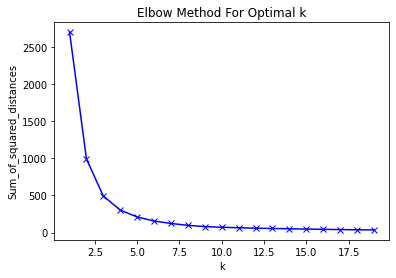

In [ ]:
np.random.seed(42)

Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    kmeans = KMeans(n_clusters=k)
    y = kmeans.fit(df[['dtv_SC', 'dwv_SC', 'dnwv_SC']])
    Sum_of_squared_distances.append(y.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Performing the multivariate k emans test

[42.22883737  6.35848787 15.75410722 26.9718401   0.24402513]
4
0.2440251267269815
       DTV      DWV     DNWV  ...   dnwv_SC  Cluster  Dist_To_Cluster_Centroid
0   1700.0   2000.0   1000.0  ...  0.436398        2                  0.375407
1  37900.0  44800.0  22700.0  ...  2.431423        4                  0.244025
2   2500.0   3000.0   1300.0  ...  0.604035        1                  0.229331
3    740.0    800.0    610.0  ...  0.120570        2                  0.057100
4     90.0     90.0     80.0  ... -1.177407        0                  0.007092

[5 rows x 9 columns]


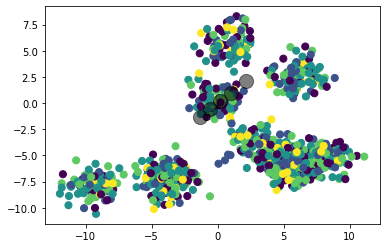

In [ ]:
X, _ = make_blobs(n_samples=len(df), centers=10, n_features=3)

num_clusters = 5
km = KMeans(n_clusters=num_clusters)

##Getting the cluster for each point
y = km.fit_predict(df[['dtv_SC', 'dwv_SC', 'dnwv_SC']])

##getting the sqaured distance of each point to each centroid
X_dist = km.transform(df[['dtv_SC', 'dwv_SC', 'dnwv_SC']])**2 

##getting coordinates of each centroid
centroids = km.cluster_centers_ 

df['Cluster'] = y

dist_to_cluster_centroid = []

for i in range(len(X_dist)):
  dist_to_cluster_centroid.append(min(X_dist[i]))

df['Dist_To_Cluster_Centroid'] = dist_to_cluster_centroid

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis')

centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

print(X_dist[1])
print(df['Cluster'][1])
print(df['Dist_To_Cluster_Centroid'][1])
print(df.head())

Finding the closest point(s) to each Centroid

In [ ]:
num_of_closest_points = round(50/num_clusters)
closest_points=[]
for i in range(num_clusters):
  temp_df = df[df['Cluster']==i]
  temp_df = temp_df.sort_values('Dist_To_Cluster_Centroid', axis= 0, ascending = True)



  ##print(temp_df[0: num_of_closest_points])
  closest_points.append(temp_df[0: num_of_closest_points])


list_of_stations =[]    
for s in range(len(closest_points)):
  n=closest_points[s]['Bahnhof_Haltestelle']
  list_of_stations.append(n)
print(list_of_stations)


  


[636          Ringgenberg
423                Lavin
158    Cinuos-chel-Brail
155           Chur Stadt
4       Acla da Fontauna
500           Mogelsberg
102          Brienz West
301            Gluringen
214            Dompierre
792               Thusis
Name: Bahnhof_Haltestelle, dtype: object, 274    Frenkendorf-Füllinsdorf
268                     Flawil
296                Glanzenberg
499                    Mitlödi
235         Emmenbrücke Gersag
328                  Heerbrugg
337            Herzogenbuchsee
336      Herrliberg-Feldmeilen
899         Zürich Stadelhofen
511                      Mosen
Name: Bahnhof_Haltestelle, dtype: object, 845    Walterswil-Striegel
85      Bischofszell Stadt
49              Bassecourt
122             Burghalden
359         Interlaken Ost
634               Rietheim
300              Glovelier
549             Niederried
188           Dagmersellen
551         Niederweningen
Name: Bahnhof_Haltestelle, dtype: object, 58           Benken
637           Rivaz
497